In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import numpy as np
import seaborn as sns
import numpy as np
from scipy.stats import rankdata, friedmanchisquare, f

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [158]:
CLF_METRICS = ["kappa"] #, "precision", "recall", "f1-score"]
CLF_MODELS = ["RandomForestClassifier"] #, "DecisionTreeClassifier", "LogisticRegression", "SVC"]

REG_METRICS = ["r2"] # , "mse", "std"]
REG_MODELS = ["RandomForestRegressor"] #, "DecisionTreeRegressor"]

DATASETS = [file for file in os.listdir("../../datasets/synthetic/") if "csv" in file]
REG_DATASETS = ["gradual_friedman.csv"]
CLF_DATASETS = list(set(DATASETS).difference(set(REG_DATASETS)))

In [159]:
def get_concept(original_idx: pd.Series, dataset: str, concept_type="last"):
    """Read the original dataframe to recover the context

    Args:
        original_idx (pd.Series): maps the metabase indexes to the original base indexes (before windowing)
        dataset (str): dataset name to be loaded
        concept_type (str, optional): how to set the window concept, it can be:
            - "last": The last concept of the batch
            - "most_frequent": The most frequent concept of the batch
    """
    filename_concept = f'../../datasets/synthetic/{dataset}'
    df_concept = pd.read_csv(filename_concept)['concept']

    concepts = []
    for idx in original_idx:
        bounds = [int(bound) for bound in idx.split(':')]
        concept_batch = df_concept[bounds[0]:bounds[1]]
        
        if concept_type == "last":
            concepts.append(concept_batch.values[-1])
        else:
            most_frequent_concept = concept_batch.value_counts().idxmax()
            concepts.append(most_frequent_concept)
    return concepts

def load_data(dataset, model, concept_type="last"):
    filename_mtl = f'../metabases/basemodel: {model} - dataset: {dataset} - with_drift_metrics.csv'
    results = pd.read_csv(filename_mtl)
    concept = get_concept(results['original_idx'], dataset, concept_type)
    results['concept'] = concept
    return results

In [160]:
def remove_unused_cols(df: pd.DataFrame) -> pd.DataFrame:
    metrics = CLF_METRICS if "kappa" in df.columns else REG_METRICS
    cols_to_keep = [
        "concept",  # concept
        *metrics,  # target cols
        *[f"last_{col}" for col in metrics],  # baseline cols
        *[col for col in df.columns if "drift" in col],  # drift metrics cols
        *[col for col in df.columns if "predicted" in col],  # mtl cols
    ]
    return df[cols_to_keep]

def gen_drift_alerts(dataset: str, model: str, metric: str) -> pd.DataFrame:
    df = load_data(dataset, model)
    offline_df = df[df["data_type"] == "offline"]
    online_df = df[df["data_type"] == "online"]
    online_df = remove_unused_cols(online_df)

    expected_mean, expected_std = offline_df[metric].mean(), offline_df[metric].std()

    for sensitivity in [0.5, 1, 1.5, 2]:
        threshold = expected_mean - expected_std * sensitivity
        online_df[f"mtl_alert_{metric}_s={sensitivity}"] = (online_df[f"predicted_{metric}"] <= threshold).astype(int)
    online_df["target_alert"] = (online_df["concept"] > 0).astype(int)
    # online_df["real_alert"] = (online_df[metric] <= threshold).astype(int)
    return online_df

In [161]:
results = {}

for dataset in DATASETS:
    try:
        metric = "kappa" if dataset in CLF_DATASETS else "r2"
        model = "RandomForestClassifier" if dataset in CLF_DATASETS else "RandomForestRegressor"
        results[dataset] = gen_drift_alerts(dataset, model, metric)
    except:
        print(dataset)

# Drift label comparison

In [162]:
def get_perf_metrics(df: pd.DataFrame, dataset: str, target_col="target_alert") -> list:
    alert_cols = [c for c in df.columns if ("_drift_" in c or "_alert" in c)]
    results = []

    for col in alert_cols:
        sensitivity = col.split("s=")[1] if "s=" in col else None
        alert_type = "drift_metrics" if "_drift_" in col else col.split("_")[0]

        # Generate confusion matrix
        cm = confusion_matrix(df[target_col], df[col], labels = [0, 1]).ravel()
        results.append({
            'dataset': dataset.replace('.csv', ''),
            'alert_col': col,
            'type': alert_type,
            'sensitivity': sensitivity,
            'True Negatives': cm[0], 
            'False Positives': cm[1], 
            'False Negatives': cm[2], 
            'True Positives': cm[3],
            'accuracy': accuracy_score(df[target_col], df[col]),
            **classification_report(df[target_col], df[col], labels = [0, 1], output_dict=True)['1']
        })
    return results

final_performances = []
for dataset, df in results.items():
    df = results[dataset]
    final_performances = [*final_performances, *get_perf_metrics(df, dataset)]
final_performances_df = pd.DataFrame(final_performances)

In [163]:
final_performances_df.head()

,dataset,alert_col,type,sensitivity,True Negatives,False Positives,False Negatives,True Positives,accuracy,precision,recall,f1-score,support
0,gradual_agrawal_unbalanced_with_noise,u_detect_drift_flag,drift_metrics,None,26,257,121,119,0.277247,0.316489,0.495833,0.386364,240
1,gradual_agrawal_unbalanced_with_noise,omv_pth_drift_flag,drift_metrics,None,283,0,240,0,0.541109,0.000000,0.000000,0.000000,240
2,gradual_agrawal_unbalanced_with_noise,psi_drift_flag,drift_metrics,None,0,283,0,240,0.458891,0.458891,1.000000,0.629096,240
3,gradual_agrawal_unbalanced_with_noise,sqsi_drift_flag,drift_metrics,None,283,0,240,0,0.541109,0.000000,0.000000,0.000000,240
4,gradual_agrawal_unbalanced_with_noise,dc_drift_flag,drift_metrics,None,0,283,0,240,0.458891,0.458891,1.000000,0.629096,240


In [164]:
def plot_heatmap(df: pd.DataFrame, metric='recall'):
    # Pivot the DataFrame to create a matrix of values
    pivot_df = df.pivot(index='dataset', columns='alert_col', values=metric)

    # Create a heat map using seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f')

    # Set labels and title
    plt.xlabel('Alert Column')
    plt.ylabel('Dataset')
    plt.title(f'{metric} heatmap')

    # Show the plot
    plt.show()

df = final_performances_df[final_performances_df["dataset"] != "gradual_friedman"]
df = df[df["alert_col"] != "target_alert"].sort_values(by="recall", ascending=False)

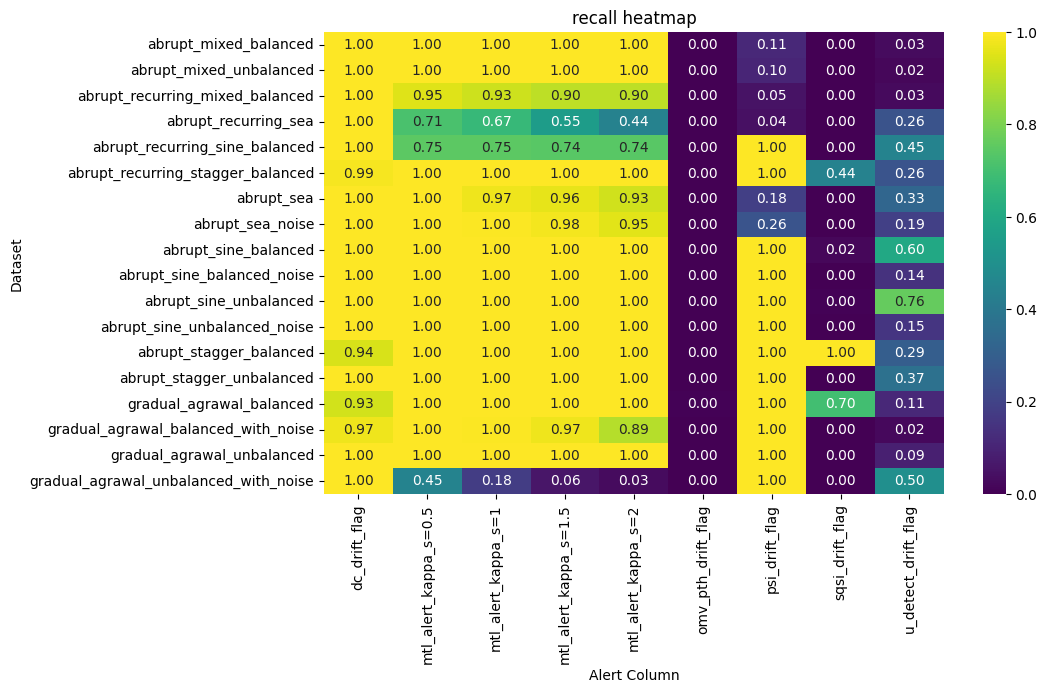

In [165]:
plot_heatmap(df, 'recall')

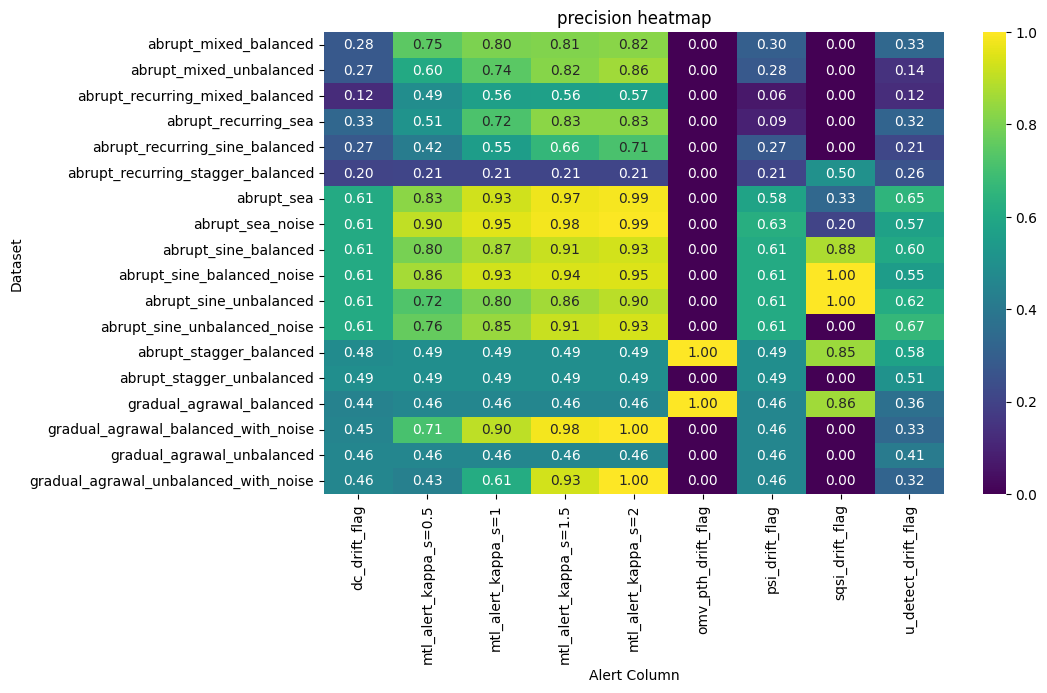

In [166]:
plot_heatmap(df, 'precision')

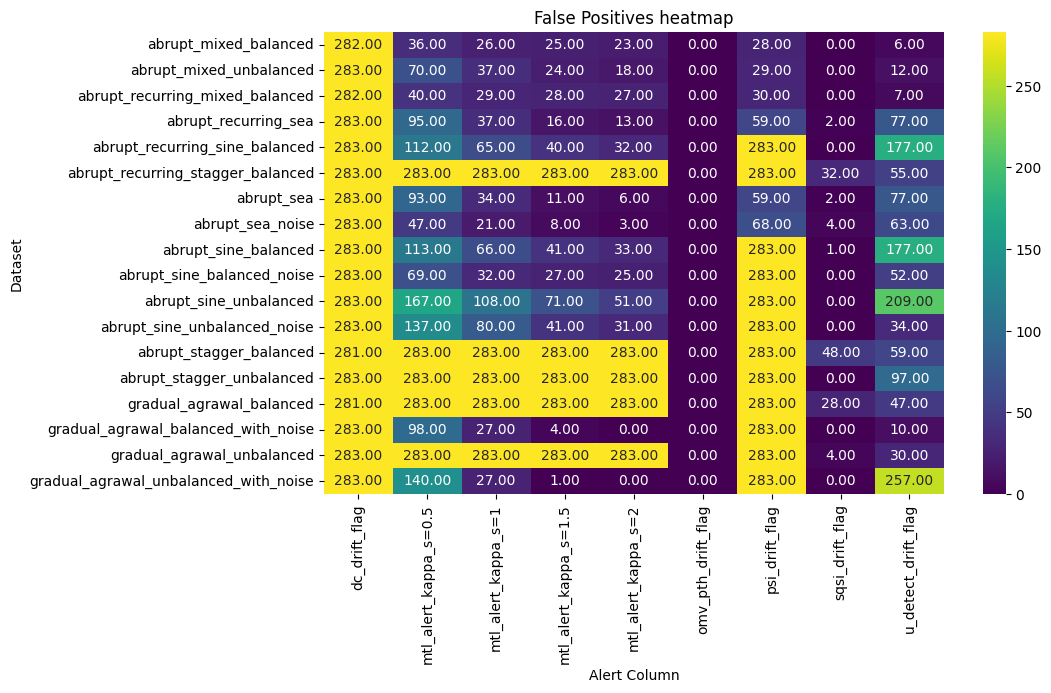

In [167]:
plot_heatmap(df, 'False Positives')

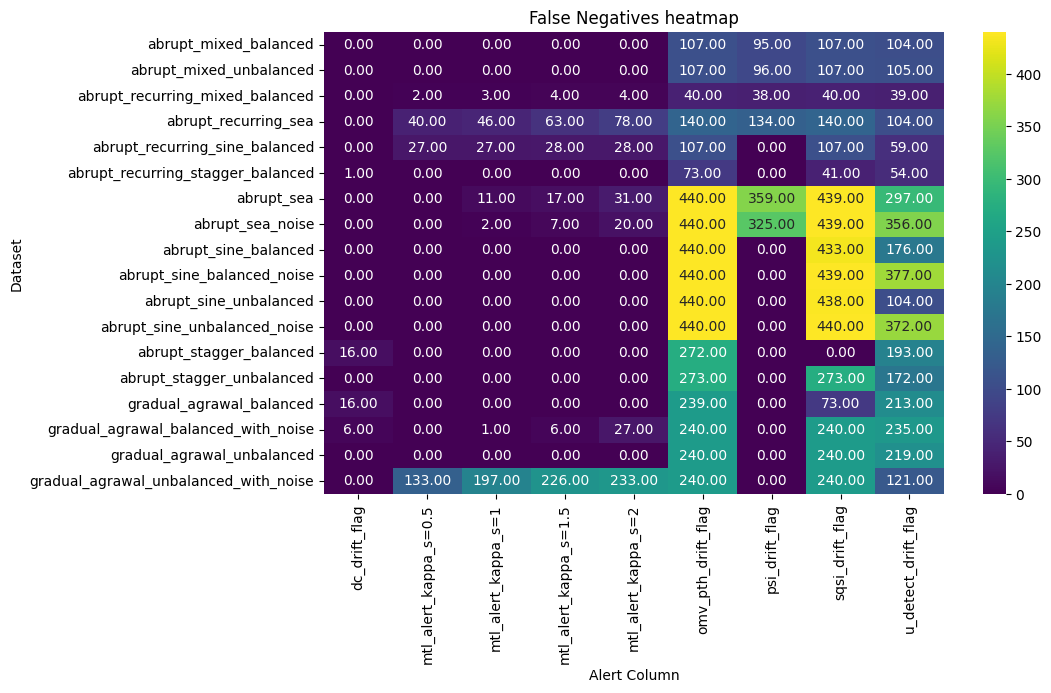

In [168]:
plot_heatmap(df, 'False Negatives')

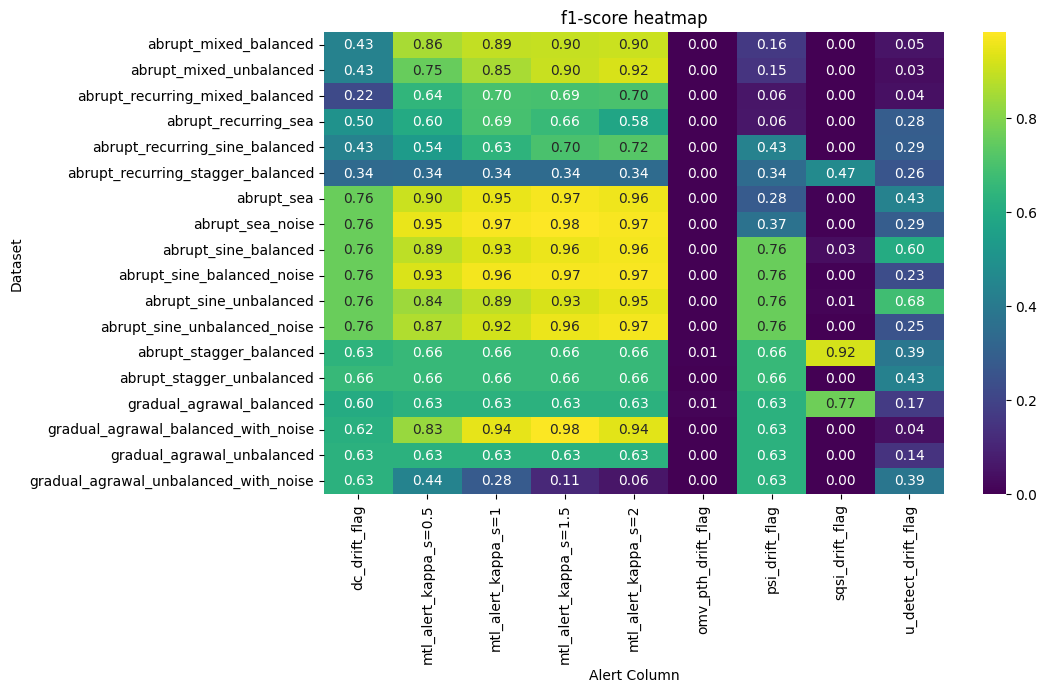

In [169]:
plot_heatmap(df, 'f1-score')

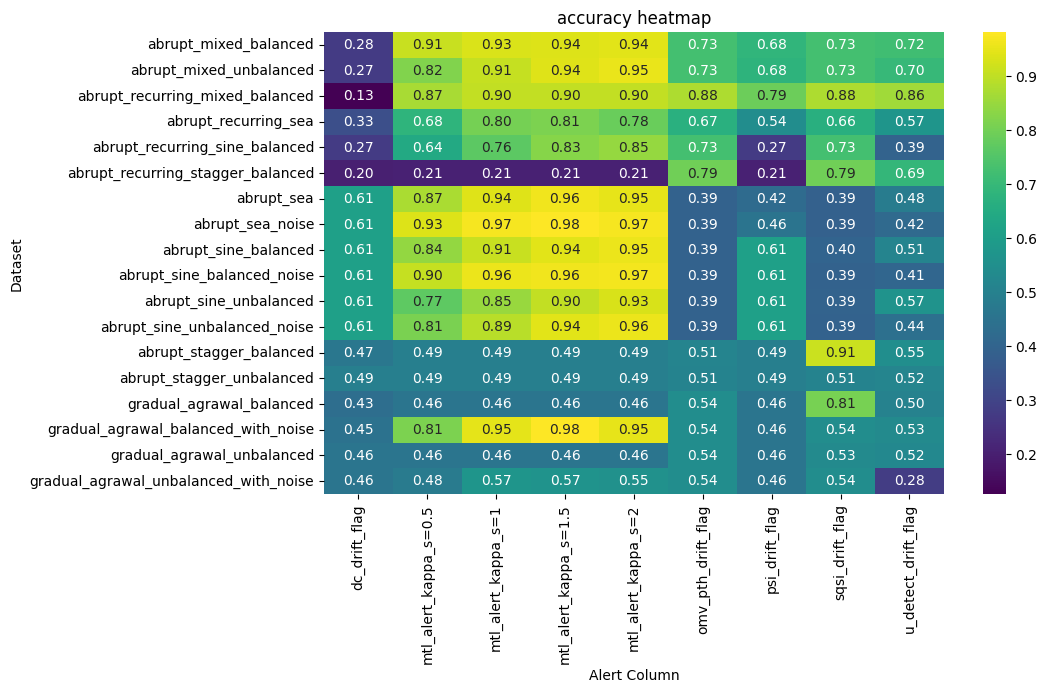

In [170]:
plot_heatmap(df, 'accuracy')

# Friedman test

In [171]:
def evaluate_classifiers_friedman(data: pd.DataFrame, metric: str):
    num_datasets, num_classifiers = data.shape

    # Compute ranks for each dataset
    ranks = []
    for i in range(num_datasets):
        ranks.append(rankdata(-np.array(data.iloc[i])))

    # Calculate average ranks
    avg_ranks = np.mean(ranks, axis=0)

    # Perform the Friedman test
    chi2, _ = friedmanchisquare(*ranks)
    df_between = num_classifiers - 1
    df_within = (num_classifiers - 1) * (num_datasets - 1)
    f_value = (num_datasets - 1) * chi2 / df_within
    p_value = 1 - f.cdf(f_value, df_between, df_within)

    # Create list of dictionaries with classifier ranks
    return [{
            "Classifier": classifier,
            "Ranking Position": pos + 1,
            "Average Rank": rank,
            "Metric": metric,
            "chi2": chi2,
            "p_value": p_value,
        } for pos, (classifier, rank) in enumerate(sorted(zip(data.columns, avg_ranks), key=lambda x: x[1]))
    ]

def evaluate_all_metrics(final_performances_df: pd.DataFrame):
    metrics = ["precision", "recall", "f1-score"]
    cols_to_drop = ["target_alert"] #, "mtl_alert_kappa_s=1.5", "mtl_alert_kappa_s=1", "mtl_alert_kappa_s=0.5"]
    results = []
    clf_results = final_performances_df.copy()
    clf_results = final_performances_df[final_performances_df["dataset"] != 'gradual_friedman']

    for metric in metrics:
        results_pivot = clf_results.pivot(index="dataset", values=metric, columns='alert_col').drop(cols_to_drop, axis=1)
        for col in results_pivot.columns:
            results_pivot = results_pivot.rename(columns={col: col.replace("dc_drift_flag", "domain_classifier").replace("_drift_flag", "").replace("_alert_kappa", "")})

        results = [*results, *evaluate_classifiers_friedman(results_pivot, metric)]
    return pd.DataFrame(results)

In [172]:
friedman_results = evaluate_all_metrics(final_performances_df)
friedman_results.head()

,Classifier,Ranking Position,Average Rank,Metric,chi2,p_value
0,mtl_s=2,1,2.222222,precision,21.022901,0.010444
1,mtl_s=1.5,2,2.833333,precision,21.022901,0.010444
2,mtl_s=1,3,3.666667,precision,21.022901,0.010444
3,mtl_s=0.5,4,4.500000,precision,21.022901,0.010444
4,psi,5,5.722222,precision,21.022901,0.010444


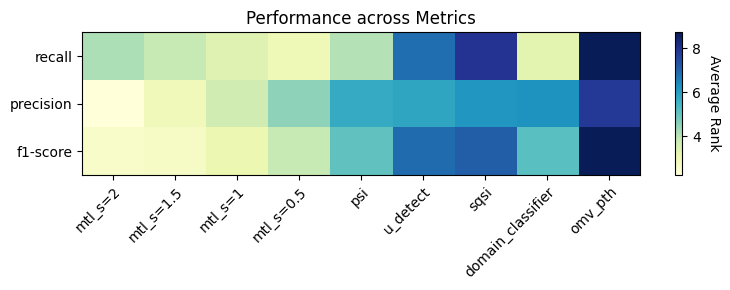

In [173]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ranking_heatmap(results: list):
    # Prepare data
    metrics = list(set(result["Metric"] for result in results))
    classifiers = list(set(result["Classifier"] for result in results))
    num_classifiers = len(classifiers)
    num_metrics = len(metrics)

    # Sort classifiers based on precision values
    sorted_classifiers = sorted(classifiers, key=lambda c: next((result["Average Rank"] for result in results if result["Classifier"] == c and result["Metric"] == "precision"), 0))

    # Create a data array for heatmap
    data = np.zeros((num_metrics, num_classifiers))
    for result in results:
        classifier_idx = sorted_classifiers.index(result["Classifier"])
        metric_idx = metrics.index(result["Metric"])
        data[metric_idx, classifier_idx] = result["Average Rank"]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 3))
    heatmap = ax.imshow(data, cmap='YlGnBu', aspect='auto')

    # Set x-axis and y-axis labels
    ax.set_xticks(np.arange(num_classifiers))
    ax.set_yticks(np.arange(num_metrics))
    ax.set_xticklabels(sorted_classifiers, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(metrics)

    # Add colorbar
    cbar = ax.figure.colorbar(heatmap, ax=ax)
    cbar.ax.set_ylabel('Average Rank', rotation=-90, va="bottom")

    # Set title and adjust layout
    ax.set_title("Performance across Metrics")
    plt.tight_layout()

    # Display the heatmap
    plt.show()

plot_ranking_heatmap(friedman_results.to_dict(orient='records'))